In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# 1. Load your encoded dataset
df_model = pd.read_csv(r"C:\Tourism\raw_data.csv")

df_model.head(5)






,UserId,VisitYear,VisitMonth,Rating,VisitMode,Attraction,Continent,Region,Country,CityName,...,Quarter,IsPeakSeason,UserVisitCount,UserAvgRating,IsGroupVisitor,AttractionVisitMode,CountrySeason,UserAvgRatingDeviation,AttractionAvgRating,AttractionRatingDeviation
0,70456,2022,10,5,Couples,Sacred Monkey Forest Sanctuary,Europe,Western Europe,United Kingdom,Guildford,...,4,0,1,5.0,0,Sacred Monkey Forest Sanctuary_Couples,United Kingdom_Autumn,0.0,4.26703,0.73297
1,7567,2022,10,5,Friends,Sacred Monkey Forest Sanctuary,America,Northern America,Canada,Ontario,...,4,0,1,5.0,1,Sacred Monkey Forest Sanctuary_Friends,Canada_Autumn,0.0,4.26703,0.73297
2,79069,2022,10,5,Family,Sacred Monkey Forest Sanctuary,America,South America,Brazil,Brazil,...,4,0,1,5.0,1,Sacred Monkey Forest Sanctuary_Family,Brazil_Autumn,0.0,4.26703,0.73297
3,31019,2022,10,3,Family,Sacred Monkey Forest Sanctuary,Europe,Central Europe,Switzerland,Zurich,...,4,0,2,3.0,1,Sacred Monkey Forest Sanctuary_Family,Switzerland_Autumn,0.0,4.26703,-1.26703
4,43611,2022,10,3,Couples,Sacred Monkey Forest Sanctuary,Europe,Western Europe,United Kingdom,Manchester,...,4,0,3,3.0,0,Sacred Monkey Forest Sanctuary_Couples,United Kingdom_Autumn,0.0,4.26703,-1.26703


In [2]:
# New features – Example
df_model['IsWeekendVisit'] = df_model['VisitMonth'].apply(lambda x: 1 if x in [6, 7, 8, 12] else 0)

import pandas as pd

# Assuming your dataframe is named 'df'

# 1. UserVisitFrequency
user_visit_freq = df_model.groupby('UserId').size().rename('UserVisitFrequency')

#

# 3. UserAttractionVariety
user_attraction_variety = df_model.groupby('UserId')['Attraction'].nunique().rename('UserAttractionVariety')

# 4. UserCountryVariety
user_country_variety = df_model.groupby('UserId')['Country'].nunique().rename('UserCountryVariety')

# 5. UserIsLocal → requires assumption or simulation
# For now, we'll assume if user's most frequent country == most visited attraction country
user_main_country = df_model.groupby('UserId')['Country'].agg(lambda x: x.mode()[0]).rename('UserMainCountry')
df_model = df_model.merge(user_main_country, on='UserId', how='left')
df_model['UserIsLocal'] = (df_model['Country'] == df_model['UserMainCountry']).astype(int)
df_model.drop(columns='UserMainCountry', inplace=True)

# 6. UserHolidayVisitor = ratio of visits that were holidays
user_holiday_ratio = df_model.groupby('UserId')['IsHolidaySeason'].mean().rename('UserHolidayVisitor')

# 7. UserGroupAffinity: if user mostly travels as group (Family or Friends)
group_modes = ['Family', 'Friends']
df_model['IsGroupVisit'] = df_model['VisitMode'].apply(lambda x: 1 if x in group_modes else 0)
user_group_affinity = df_model.groupby('UserId')['IsGroupVisit'].mean().rename('UserGroupAffinity')
df_model.drop(columns='IsGroupVisit', inplace=True)

# 🔗 Merge all features into your main DataFrame
user_features = pd.concat([
    user_visit_freq,
    user_attraction_variety,
    user_country_variety,
    user_holiday_ratio,
    user_group_affinity
], axis=1).reset_index()

# Merge back to main df
df_model = df_model.merge(user_features, on='UserId', how='left')
# User-Attraction Interaction Features
df_model['UserAttractionRating'] = df_model.groupby(['UserId', 'Attraction'])['Rating'].transform('mean')
df_model['UserAttractionVisitCount'] = df_model.groupby(['UserId', 'Attraction'])['VisitYear'].transform('count')
df_model['UserAttractionPreference'] = df_model.groupby('UserId')['Rating'].transform('mean')

# User Profile Features
df_model['UserVisitModeFrequency'] = df_model.groupby(['UserId', 'VisitMode'])['VisitYear'].transform('count')
df_model['UserRegionPreference'] = df_model.groupby(['UserId', 'Region'])['VisitYear'].transform('count')
df_model['UserSeasonPreference'] = df_model.groupby(['UserId', 'Season'])['VisitYear'].transform('count')
df_model['TotalUserVisits'] = df_model.groupby('UserId')['VisitYear'].transform('count')

# Attraction Profile Features
df_model['AttractionPopularity'] = df_model.groupby('Attraction')['Rating'].transform('mean')
df_model['AttractionSeasonalityScore'] = df_model.groupby(['Attraction', 'Season'])['Rating'].transform('mean')
df_model['AttractionVisitMode'] = df_model.groupby('Attraction')['VisitMode'].transform(lambda x: x.mode()[0])

# Time-Based Features
df_model['IsRecentVisit'] = df_model['VisitYear'] == df_model['VisitYear'].max()
df_model['TimeOfYearEffect'] = df_model['VisitMonth'].apply(lambda x: 1 if x in [6, 7, 8] else 0)

# User-Attraction Interaction Aggregates
df_model['AttractionRatingVariance'] = df_model.groupby('Attraction')['Rating'].transform('var')
df_model['UserAttractionRatingDifference'] = df_model['UserAvgRating'] - df_model['AttractionAvgRating']

# Cross-Feature Interaction
df_model['Attraction_VisitMode_Interaction'] = df_model['Attraction'] + '_' + df_model['VisitMode']
df_model['User_VisitMode_Interaction'] = df_model['UserId'].astype(str) + '_' + df_model['VisitMode']

# Popularity and Engagement Features
df_model['AttractionEngagementScore'] = df_model['AttractionPopularity'] * df_model.groupby('Attraction')['Rating'].transform('count')
df_model['UserEngagementScore'] = df_model['UserAvgRating'] * df_model['UserVisitCount']


In [3]:
df_model.to_csv("Added_data.csv", index=False)
print('Saved to Added_data.csv')

Saved to Added_data.csv


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 1: Copy the original DataFrame
df_encoded = df_model.copy()

# Step 2: Label Encode binary 'IsHolidayVisit' column
if 'IsHolidayVisit' in df_encoded.columns:
    le = LabelEncoder()
    df_encoded['IsHolidayVisit'] = le.fit_transform(df_encoded['IsHolidayVisit'])

# Step 3: Define all other categorical columns to One-Hot Encode
one_hot_cols = [
    'VisitMode', 
    'Attraction', 
    'Continent', 
    'Region', 
    'Country', 
    'CityName', 
    'Season', 
    'VisitModeGrouped', 
]

# Step 4: Apply One-Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols, drop_first=True)

# Now df_encoded is fully encoded and ready for modeling


In [5]:
df_encoded.to_csv("Visitencoded_dataset.csv", index=False)

# ✅ Save as Pickle
df_encoded.to_pickle("Visitencoded_dataset.pkl")

print("✅ Encoded data saved as 'encoded_dataset.csv' and 'encoded_dataset.pkl'")

✅ Encoded data saved as 'encoded_dataset.csv' and 'encoded_dataset.pkl'


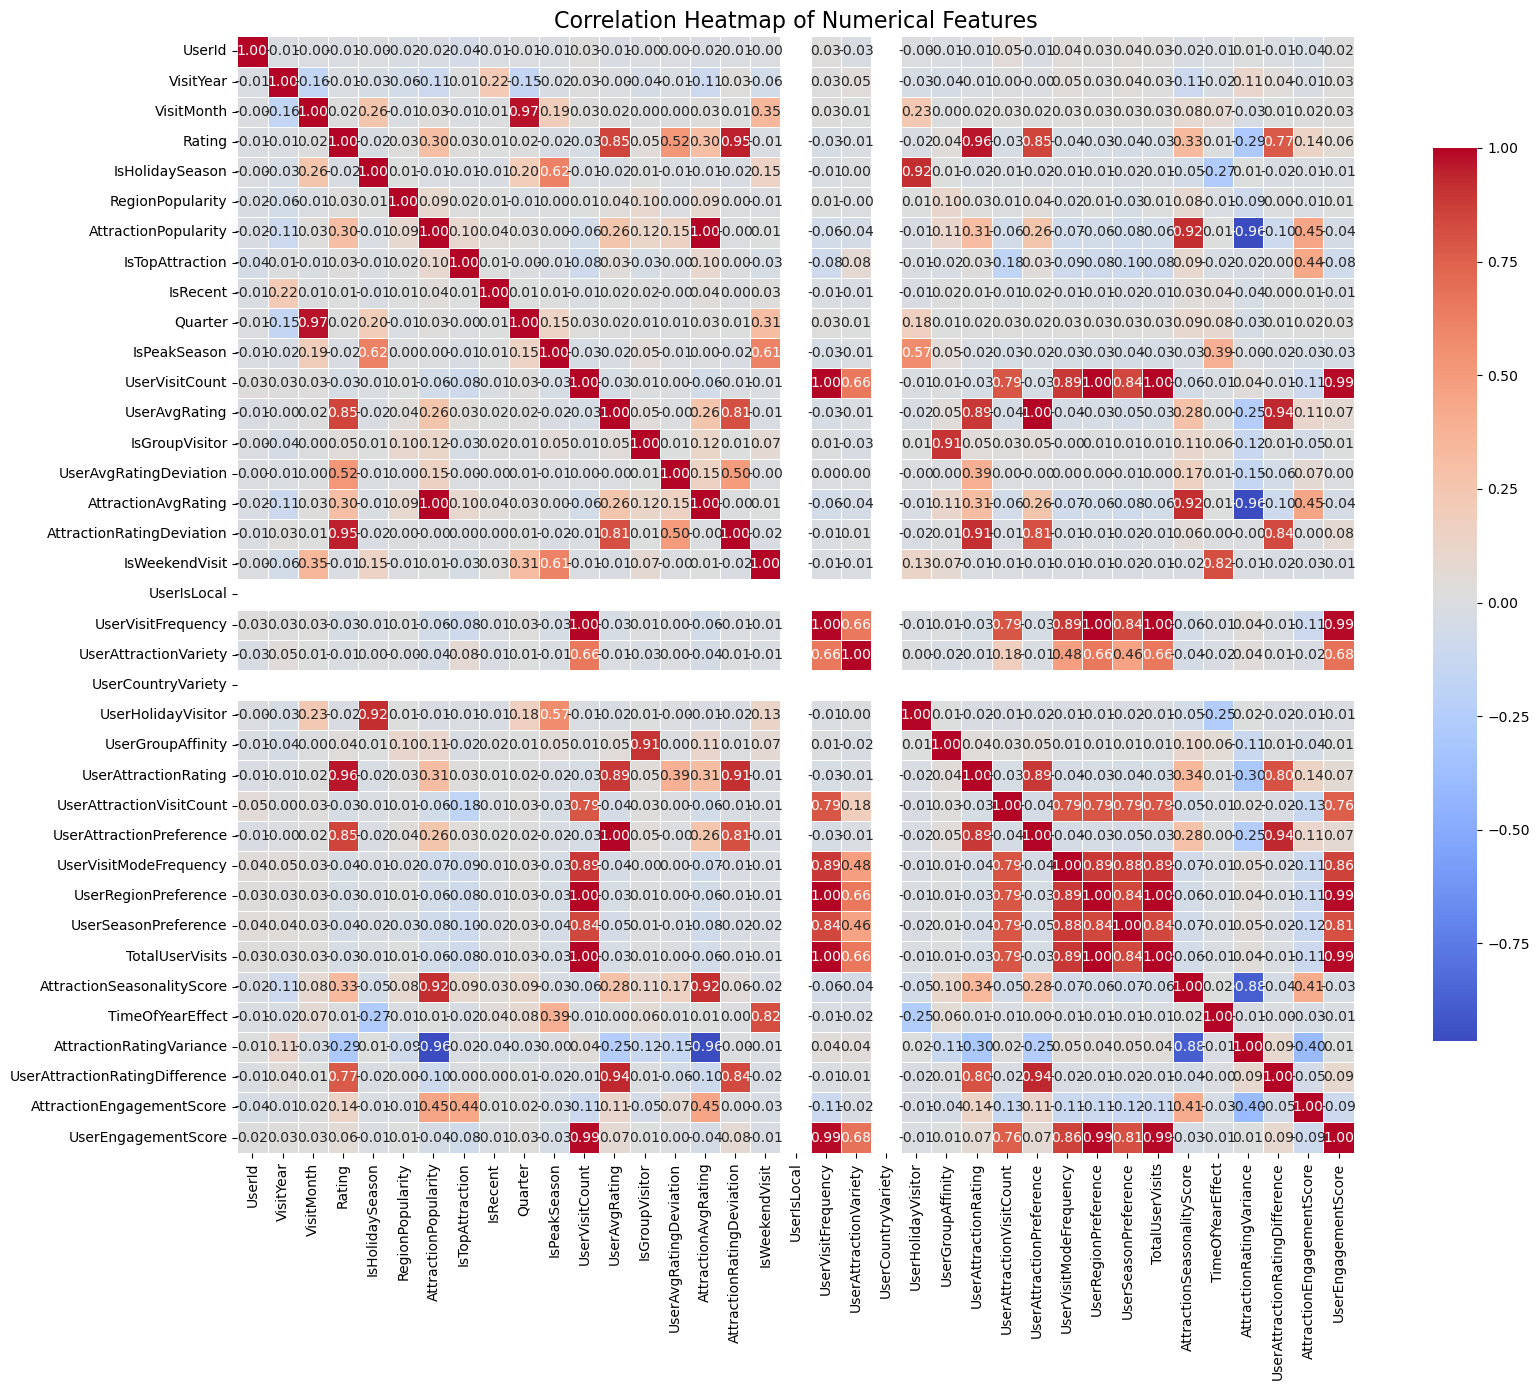

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df_model = pd.read_csv(r'C:\Tourism\Visitencoded_dataset.csv')

# Select only numeric columns
numeric_cols = df_model.select_dtypes(include=['int64', 'float64']).columns
df_numeric = df_model[numeric_cols]

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap with stronger visibility
plt.figure(figsize=(18, 14))  # Increase figure size
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

df = pd.read_csv(r'C:\Tourism\Added_data.csv')

# Step 1: Define selected features and include target variable
selected_features = [
    'UserId',
    'VisitMonth', 
    'Attraction',	
    'UserVisitFrequency',
    'UserHolidayVisitor',
    'UserAttractionVisitCount',
    'UserEngagementScore',
    'UserCountryVariety',
    'UserAttractionVariety',
    'AttractionEngagementScore',
    'UserGroupAffinity',
    'VisitMode'  # Target variable
]

# Step 2: Extract the subset from df_model
df_selected = df[selected_features].copy()

# Step 3: Save to CSV
df_selected.to_csv('Visitselected_features.csv', index=False)

print("✅ File 'Visitselected_features.csv' saved successfully.")

✅ File 'Visitselected_features.csv' saved successfully.


In [20]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder

# Load your CSV file
df = pd.read_csv("Visitselected_features.csv")

# One-hot encode only 'Attraction' (exclude 'VisitMode')
df_encoded = pd.get_dummies(df, columns=['Attraction'], drop_first=False)

# Label encode the 'VisitMode' target column
le = LabelEncoder()
df_encoded['VisitMode'] = le.fit_transform(df_encoded['VisitMode'])

# Convert any boolean columns to int (0/1)
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# Save the encoded DataFrame to CSV
df_encoded.to_csv("encoded_visit_data.csv", index=False)

# Save the encoded DataFrame to pickle
with open("encoded_visit_data.pkl", "wb") as f:
    pickle.dump(df_encoded, f)

# Save the label encoder for later inverse_transform
with open("visitmode_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Files saved: encoded_visit_data.csv, encoded_visit_data.pkl, visitmode_label_encoder.pkl")


✅ Files saved: encoded_visit_data.csv, encoded_visit_data.pkl, visitmode_label_encoder.pkl


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

# Load encoded data
df_encoded = pd.read_csv("encoded_visit_data.csv")

# Numerical columns to scale
numerical_cols = [
    'VisitMonth',
    'UserVisitFrequency',
    'UserHolidayVisitor',
    'UserAttractionVisitCount',
    'UserEngagementScore',
    'UserCountryVariety',
    'UserAttractionVariety',
    'AttractionEngagementScore',
    'UserGroupAffinity',
    
]

# Initialize scaler
scaler = StandardScaler()

# Scale numerical columns only
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Save scaled data to CSV and pickle
df_encoded.to_csv("encoded_scaled_visit_data.csv", index=False)

with open("visit_features_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaling done. Saved encoded_scaled_visit_data.csv and scaler pickle.")


Scaling done. Saved encoded_scaled_visit_data.csv and scaler pickle.


In [22]:
import pandas as pd

df = pd.read_csv(r'C:\Tourism\encoded_scaled_visit_data.csv')

visitmode_cols = [col for col in df.columns if 'VisitMode' in col]
print("Columns containing 'VisitMode':", visitmode_cols)


Columns containing 'VisitMode': ['VisitMode']


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle

# Load the scaled and encoded data
df = pd.read_csv(r'C:\Tourism\encoded_scaled_visit_data.csv')

# Define feature columns - scaled numerical + one-hot encoded categorical columns except target
# If you want to use all columns except 'VisitMode' as features:
features = df.columns.drop('VisitMode')

X = df[features]
y = df['VisitMode']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions on test set
y_pred = model.predict(X_test)

# Evaluate
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Save the trained model
with open(r'C:\Tourism\random_forest_visitmode_model.pkl', 'wb') as f:
    pickle.dump(model, f)


✅ Accuracy: 0.674633915918753

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.27      0.35       135
           1       0.79      0.87      0.83      4337
           2       0.65      0.68      0.66      2995
           3       0.54      0.50      0.51      2190
           4       0.39      0.24      0.30       928

    accuracy                           0.67     10585
   macro avg       0.57      0.51      0.53     10585
weighted avg       0.66      0.67      0.66     10585



In [25]:
# Save the feature columns used for training
import pickle

# Assuming X_train is your feature dataframe used for training
with open("c:/Tourism/visit_dummy_columns.pkl", "wb") as f:
    pickle.dump(list(X_train.columns), f)


Accuracy: 0.674633915918753
              precision    recall  f1-score   support

           0       0.48      0.27      0.35       135
           1       0.79      0.87      0.83      4337
           2       0.65      0.68      0.66      2995
           3       0.54      0.50      0.51      2190
           4       0.39      0.24      0.30       928

    accuracy                           0.67     10585
   macro avg       0.57      0.51      0.53     10585
weighted avg       0.66      0.67      0.66     10585



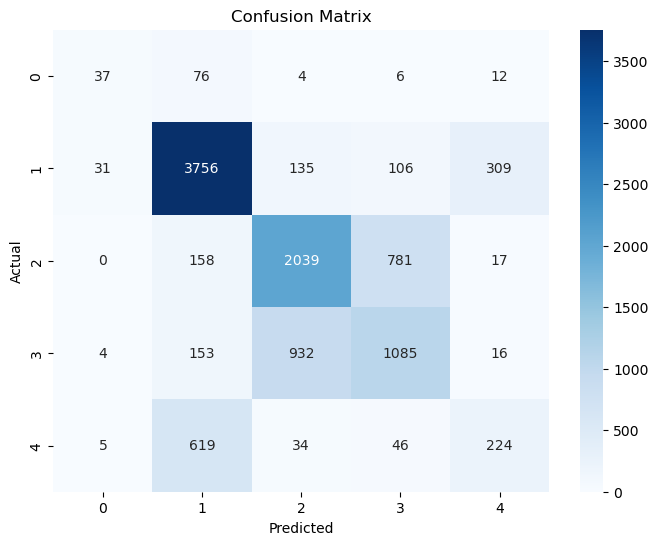

ROC-AUC Score (OVR): 0.8474588364980713


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your scaled encoded data
df = pd.read_csv("encoded_scaled_visit_data.csv")

# Define features and target
features = df.columns.drop('VisitMode')  # Assuming label encoded VisitMode column
X = df[features]
y = df['VisitMode']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Score (One-vs-Rest for multiclass)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("ROC-AUC Score (OVR):", roc_auc)
